# Flower classfication project  
   
## Contents      

&nbsp;&nbsp;&nbsp;**[1. Aims and objectives](#1.-Aims-and-objectives)**   
&nbsp;&nbsp;&nbsp;**[2. Literature review](#2.-Literature-review)**   
&nbsp;&nbsp;&nbsp;**[3. Method](#3.-Method)**   
&nbsp;&nbsp;&nbsp;**[4. Result](#4.-Result)**   
&nbsp;&nbsp;&nbsp;**[5. Discussion and conclusion](#5.-Discussion-and-conclusion)**   
&nbsp;&nbsp;&nbsp;**[6. Reference](#6.-Reference)**   

## 1. Aims and objectives

## 2. Literature review

## 3. Method    
   
### Data preparation   
   
The datasets had been retrieved from tensorflow dataset and divided into three: 80% for training data, 10% for validation, and 10% for test data. The image data were plotted with matplotlib

In [1]:
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

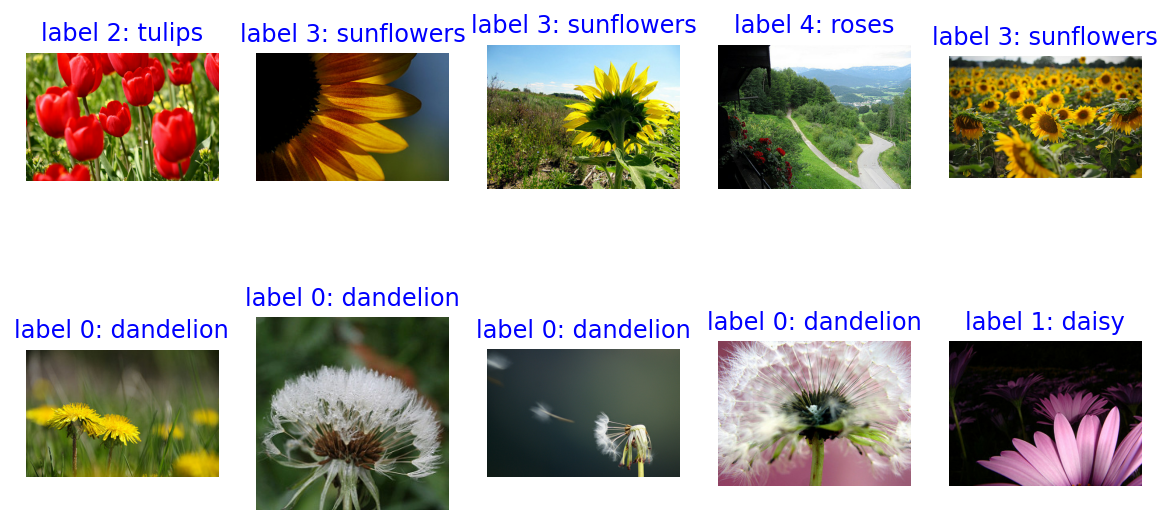

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5)) # these images had been shuffeld by the publisher?

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}', color='blue')
    plt.axis('off')

In [3]:
print(metadata.features['label'].names) # it has 5 classes. 0: Dandelion, 1: Daisy, 2: Tulips, 3: Sunflowers, 4: Roses

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


Since neural networks receive inputs of the same size, all of the image were resized to the size of 160x160.

In [4]:
import tensorflow as tf
IMG_SIZE = 160 # All images will be resized to 160x160. If I scale the images up, will the accuracy increase?

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # type casting
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # How does this 'resizing' work?
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

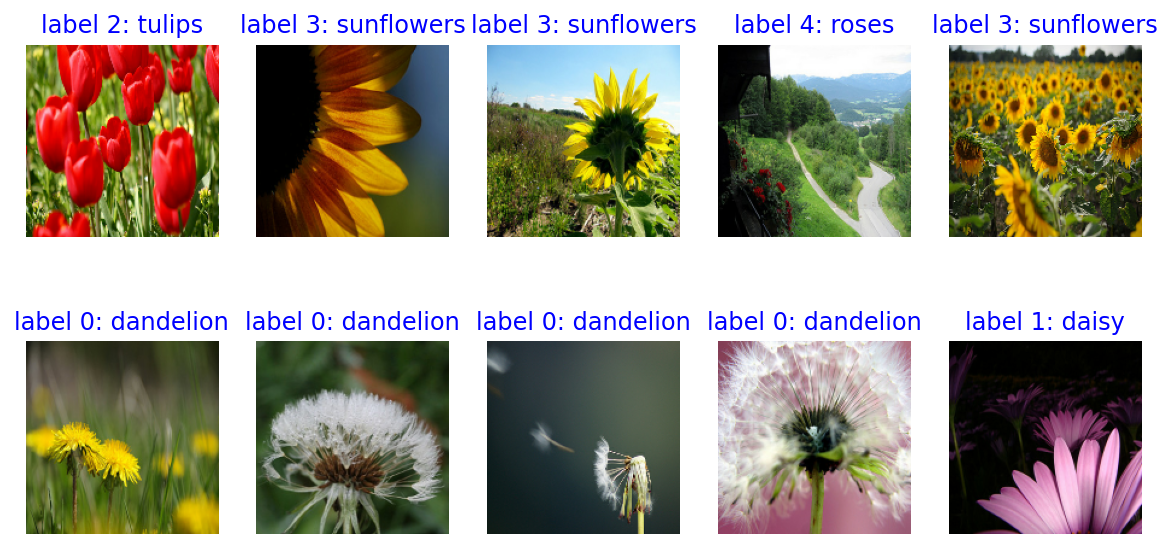

In [5]:
plt.figure(figsize=(10, 5)) 


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}', color='blue')
    plt.axis('off')

A simple Convolutional Neural Network model was first implemented. The model is comprised of three pairs of a convolutional and maxpooling layer and two dense layers for after flattening.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

Configuring the model for training,

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

The training data were batched into the size of 32.

In [9]:
BATCH_SIZE = 32 # determining batch size which will be trained for one step.
SHUFFLE_BUFFER_SIZE = 1000 # shuffles the training data.

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

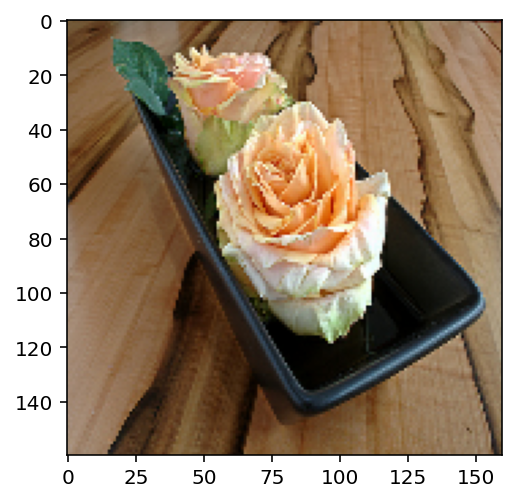

In [11]:
for image_batch, label_batch in train_batches.take(1):
    image_batch = (image_batch + 1) / 2
    plt.imshow(image_batch[0])
    pass

image_batch.shape, label_batch.shape

### Train dataset

In [12]:
validation_steps = 12
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 3s 251ms/step - loss: 1.6135 - accuracy: 0.1853
initial loss: 1.61
initial accuracy: 0.19


In [13]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 12s 130ms/step - loss: 1.4368 - accuracy: 0.3876 - val_loss: 1.1229 - val_accuracy: 0.5477
Epoch 2/10
92/92 [==============================] - 3s 29ms/step - loss: 1.1127 - accuracy: 0.5521 - val_loss: 1.1553 - val_accuracy: 0.5095
Epoch 3/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9805 - accuracy: 0.6226 - val_loss: 1.0019 - val_accuracy: 0.5967
Epoch 4/10
92/92 [==============================] - 3s 29ms/step - loss: 0.8762 - accuracy: 0.6686 - val_loss: 0.9868 - val_accuracy: 0.6185
Epoch 5/10
92/92 [==============================] - 3s 29ms/step - loss: 0.7597 - accuracy: 0.7262 - val_loss: 0.9878 - val_accuracy: 0.6022
Epoch 6/10
92/92 [==============================] - 3s 29ms/step - loss: 0.6584 - accuracy: 0.7708 - val_loss: 1.1436 - val_accuracy: 0.5341
Epoch 7/10
92/92 [==============================] - 3s 30ms/step - loss: 0.5618 - accuracy: 0.8110 - val_loss: 0.9935 - val_accuracy: 0.6403
Epoch 8/10


### Using VGG16 model

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
print(image_batch.shape) # batch of images
feature_batch = base_model(image_batch)
print(feature_batch.shape) # output batch

# Create a new classifier with global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # (5, 5, 512) -> (1, 1, 512)
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) 

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 512)
(32, 512)
(32, 5)


In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [16]:
base_model.trainable = False # base model (VGG16) is not set to be trained

VGG16_model = Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
base_learning_rate = 0.0001
VGG16_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

validation_steps = 12
loss0, accuracy0 = VGG16_model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 15s 1s/step - loss: 1.6141 - accuracy: 0.2180
initial loss: 1.61
initial accuracy: 0.22


In [30]:
EPOCHS = 10

history = VGG16_model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 9s 94ms/step - loss: 0.6383 - accuracy: 0.7929 - val_loss: 0.6266 - val_accuracy: 0.7738
Epoch 2/10
92/92 [==============================] - 9s 97ms/step - loss: 0.6029 - accuracy: 0.8096 - val_loss: 0.6235 - val_accuracy: 0.7684
Epoch 3/10
92/92 [==============================] - 9s 97ms/step - loss: 0.5770 - accuracy: 0.8188 - val_loss: 0.5803 - val_accuracy: 0.7956
Epoch 4/10
92/92 [==============================] - 9s 100ms/step - loss: 0.5504 - accuracy: 0.8215 - val_loss: 0.5661 - val_accuracy: 0.7984
Epoch 5/10
92/92 [==============================] - 9s 95ms/step - loss: 0.5293 - accuracy: 0.8307 - val_loss: 0.5629 - val_accuracy: 0.8011
Epoch 6/10
92/92 [==============================] - 9s 96ms/step - loss: 0.5140 - accuracy: 0.8351 - val_loss: 0.5484 - val_accuracy: 0.8065
Epoch 7/10
92/92 [==============================] - 9s 97ms/step - loss: 0.4977 - accuracy: 0.8362 - val_loss: 0.5401 - val_accuracy: 0.8147
Epoch 8/10
9

## 4. Result

### The simple model

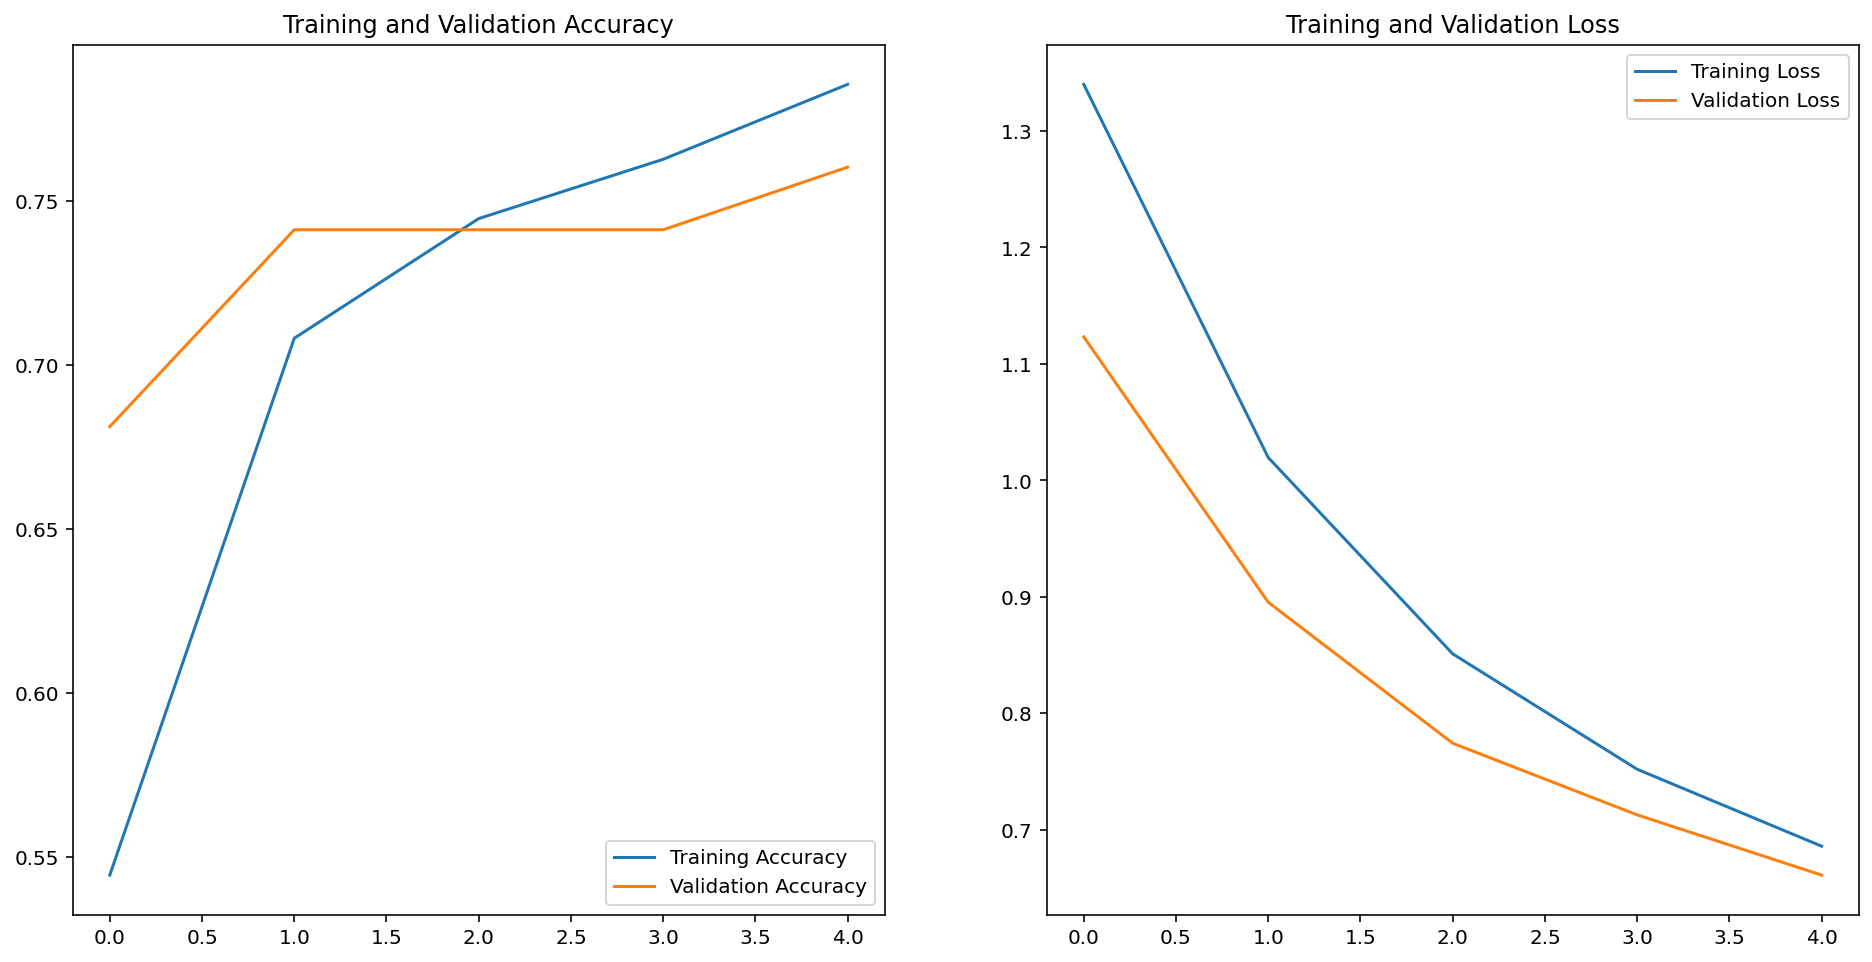

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.29471478e-02, 6.17579464e-03, 8.23462546e-01, 5.70962653e-02,
        2.03183107e-02],
       [8.39216471e-01, 1.58781454e-01, 1.43769884e-03, 8.17805048e-05,
        4.82559524e-04],
       [8.37558746e-01, 2.57649142e-02, 5.61224446e-02, 8.02312568e-02,
        3.22609500e-04],
       [1.23858631e-01, 2.47170925e-01, 2.47785270e-01, 1.57260485e-02,
        3.65459055e-01],
       [9.45724785e-01, 2.63869129e-02, 5.35189221e-03, 1.43347308e-03,
        2.11030170e-02],
       [7.68890440e-01, 1.57533228e-01, 5.74790575e-02, 2.07476807e-03,
        1.40225394e-02],
       [2.58348361e-02, 6.01684563e-02, 8.63215625e-01, 1.23240007e-02,
        3.84570546e-02],
       [6.84499979e-01, 8.08577389e-02, 8.84773955e-02, 5.36526442e-02,
        9.25122499e-02],
       [1.64240077e-01, 1.93739892e-04, 3.43937390e-02, 8.01086366e-01,
        8.61620574e-05],
       [9.82922554e-01, 1.65414102e-02, 2.01298273e-04, 6.74533585e-05,
        2.67234951e-04],
       [9.95613933e-01, 3.4453

In [25]:
import numpy as np
predictions = np.argmax(predictions, axis=1) # argmax returns indices of the max values along an axis.
predictions

array([2, 0, 0, 4, 0, 0, 2, 0, 3, 0, 0, 0, 3, 2, 0, 3, 2, 0, 1, 2, 2, 0,
       1, 0, 0, 0, 2, 0, 2, 0, 0, 0])

In [ ]:
count = 0   
for image, label, prediction in zip(images, labels, predictions):
  if label == prediction:
    count += 1
  
print('The model predicts correctly with', count / 32 * 100, 'of probability')    # accuracy percentage

### VGG16 model

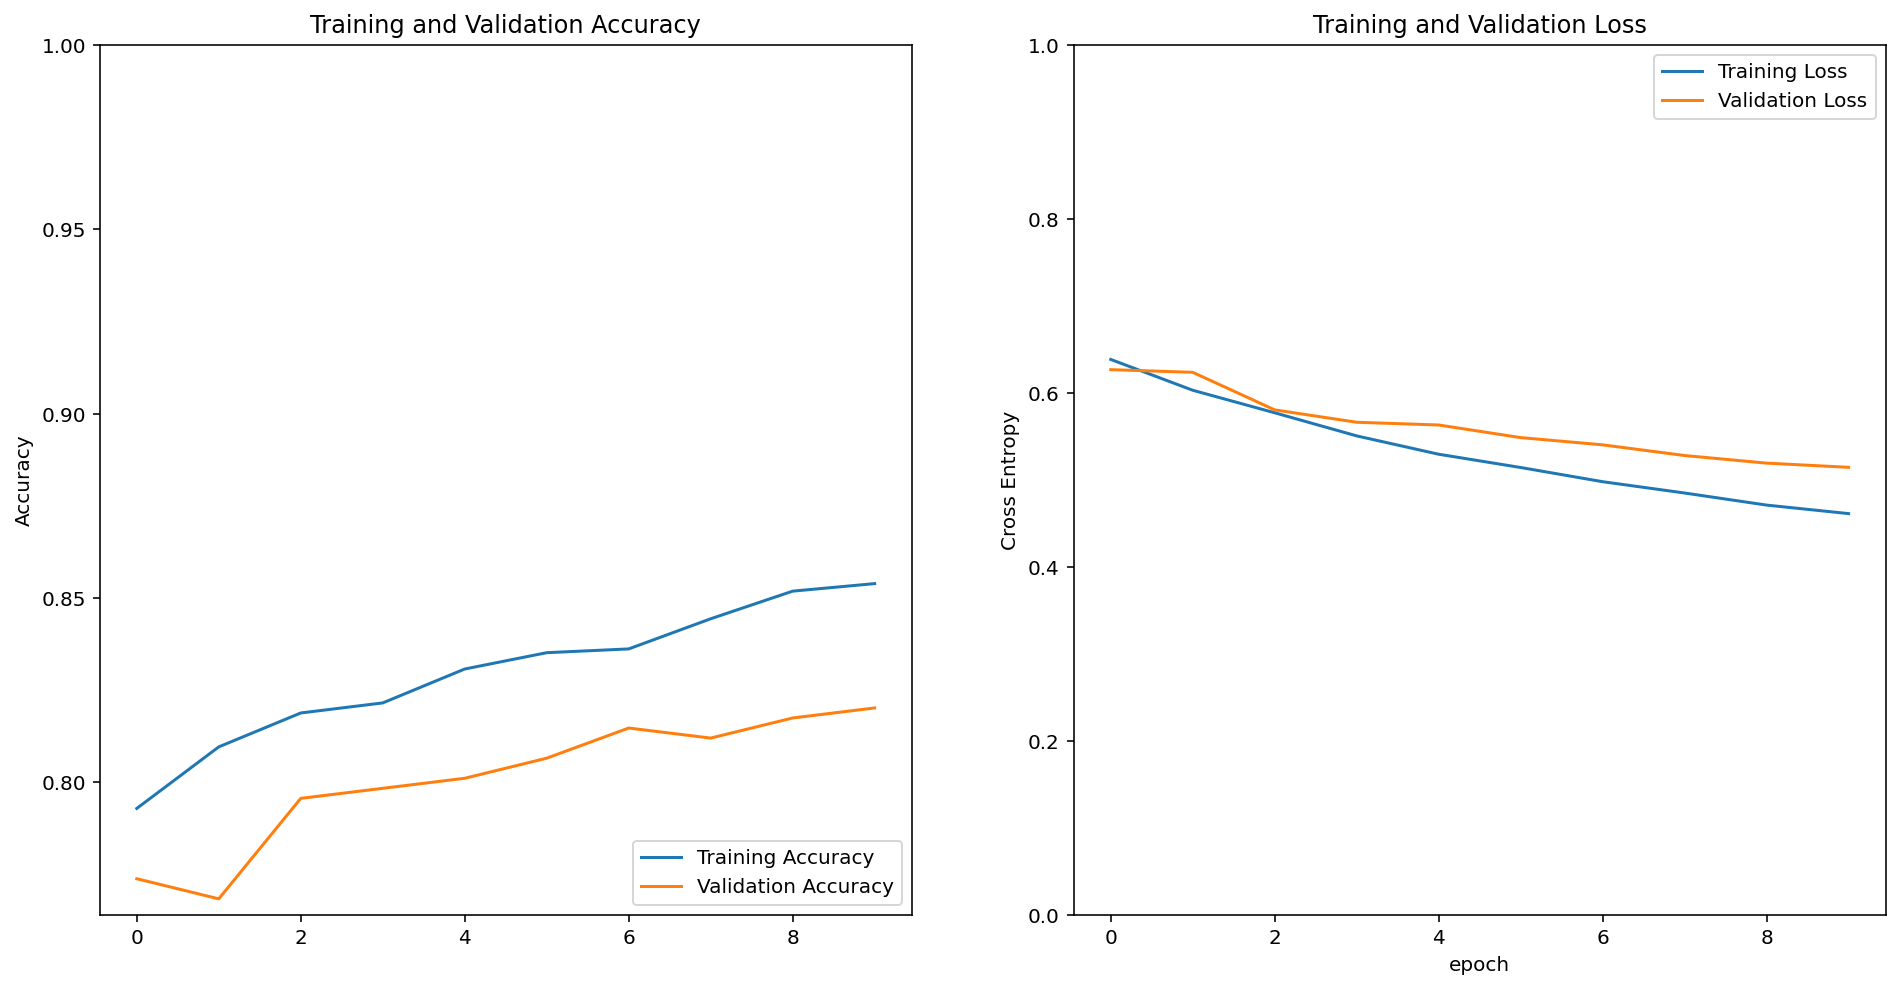

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    vgg_predictions = VGG16_model.predict(image_batch)
    pass

vgg_predictions

array([[1.83579214e-02, 6.28613606e-02, 8.10429573e-01, 2.82373820e-02,
        8.01138058e-02],
       [9.98932183e-01, 9.63287835e-04, 7.23900030e-06, 5.63782778e-05,
        4.09716995e-05],
       [7.45206773e-01, 1.29962608e-01, 1.71181932e-02, 9.20123681e-02,
        1.57000255e-02],
       [1.96309155e-03, 1.19751943e-02, 6.58570349e-01, 7.29281036e-03,
        3.20198536e-01],
       [6.45849884e-01, 3.10383946e-01, 1.45232966e-02, 1.19250985e-02,
        1.73178110e-02],
       [9.23992395e-01, 5.10745756e-02, 4.78838384e-03, 1.90606024e-02,
        1.08410337e-03],
       [5.84052037e-03, 9.80442576e-03, 8.83815348e-01, 7.05062523e-02,
        3.00333891e-02],
       [3.85560304e-01, 5.14304042e-01, 8.63237365e-04, 9.70127434e-02,
        2.25967797e-03],
       [7.27607682e-03, 1.50870671e-03, 1.89004485e-02, 9.06755567e-01,
        6.55592307e-02],
       [9.99131382e-01, 8.03534931e-04, 2.03362379e-06, 6.10134921e-05,
        2.08959523e-06],
       [9.68339622e-01, 2.7078

In [34]:
vgg_predictions = np.argmax(vgg_predictions, axis=1)
vgg_predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

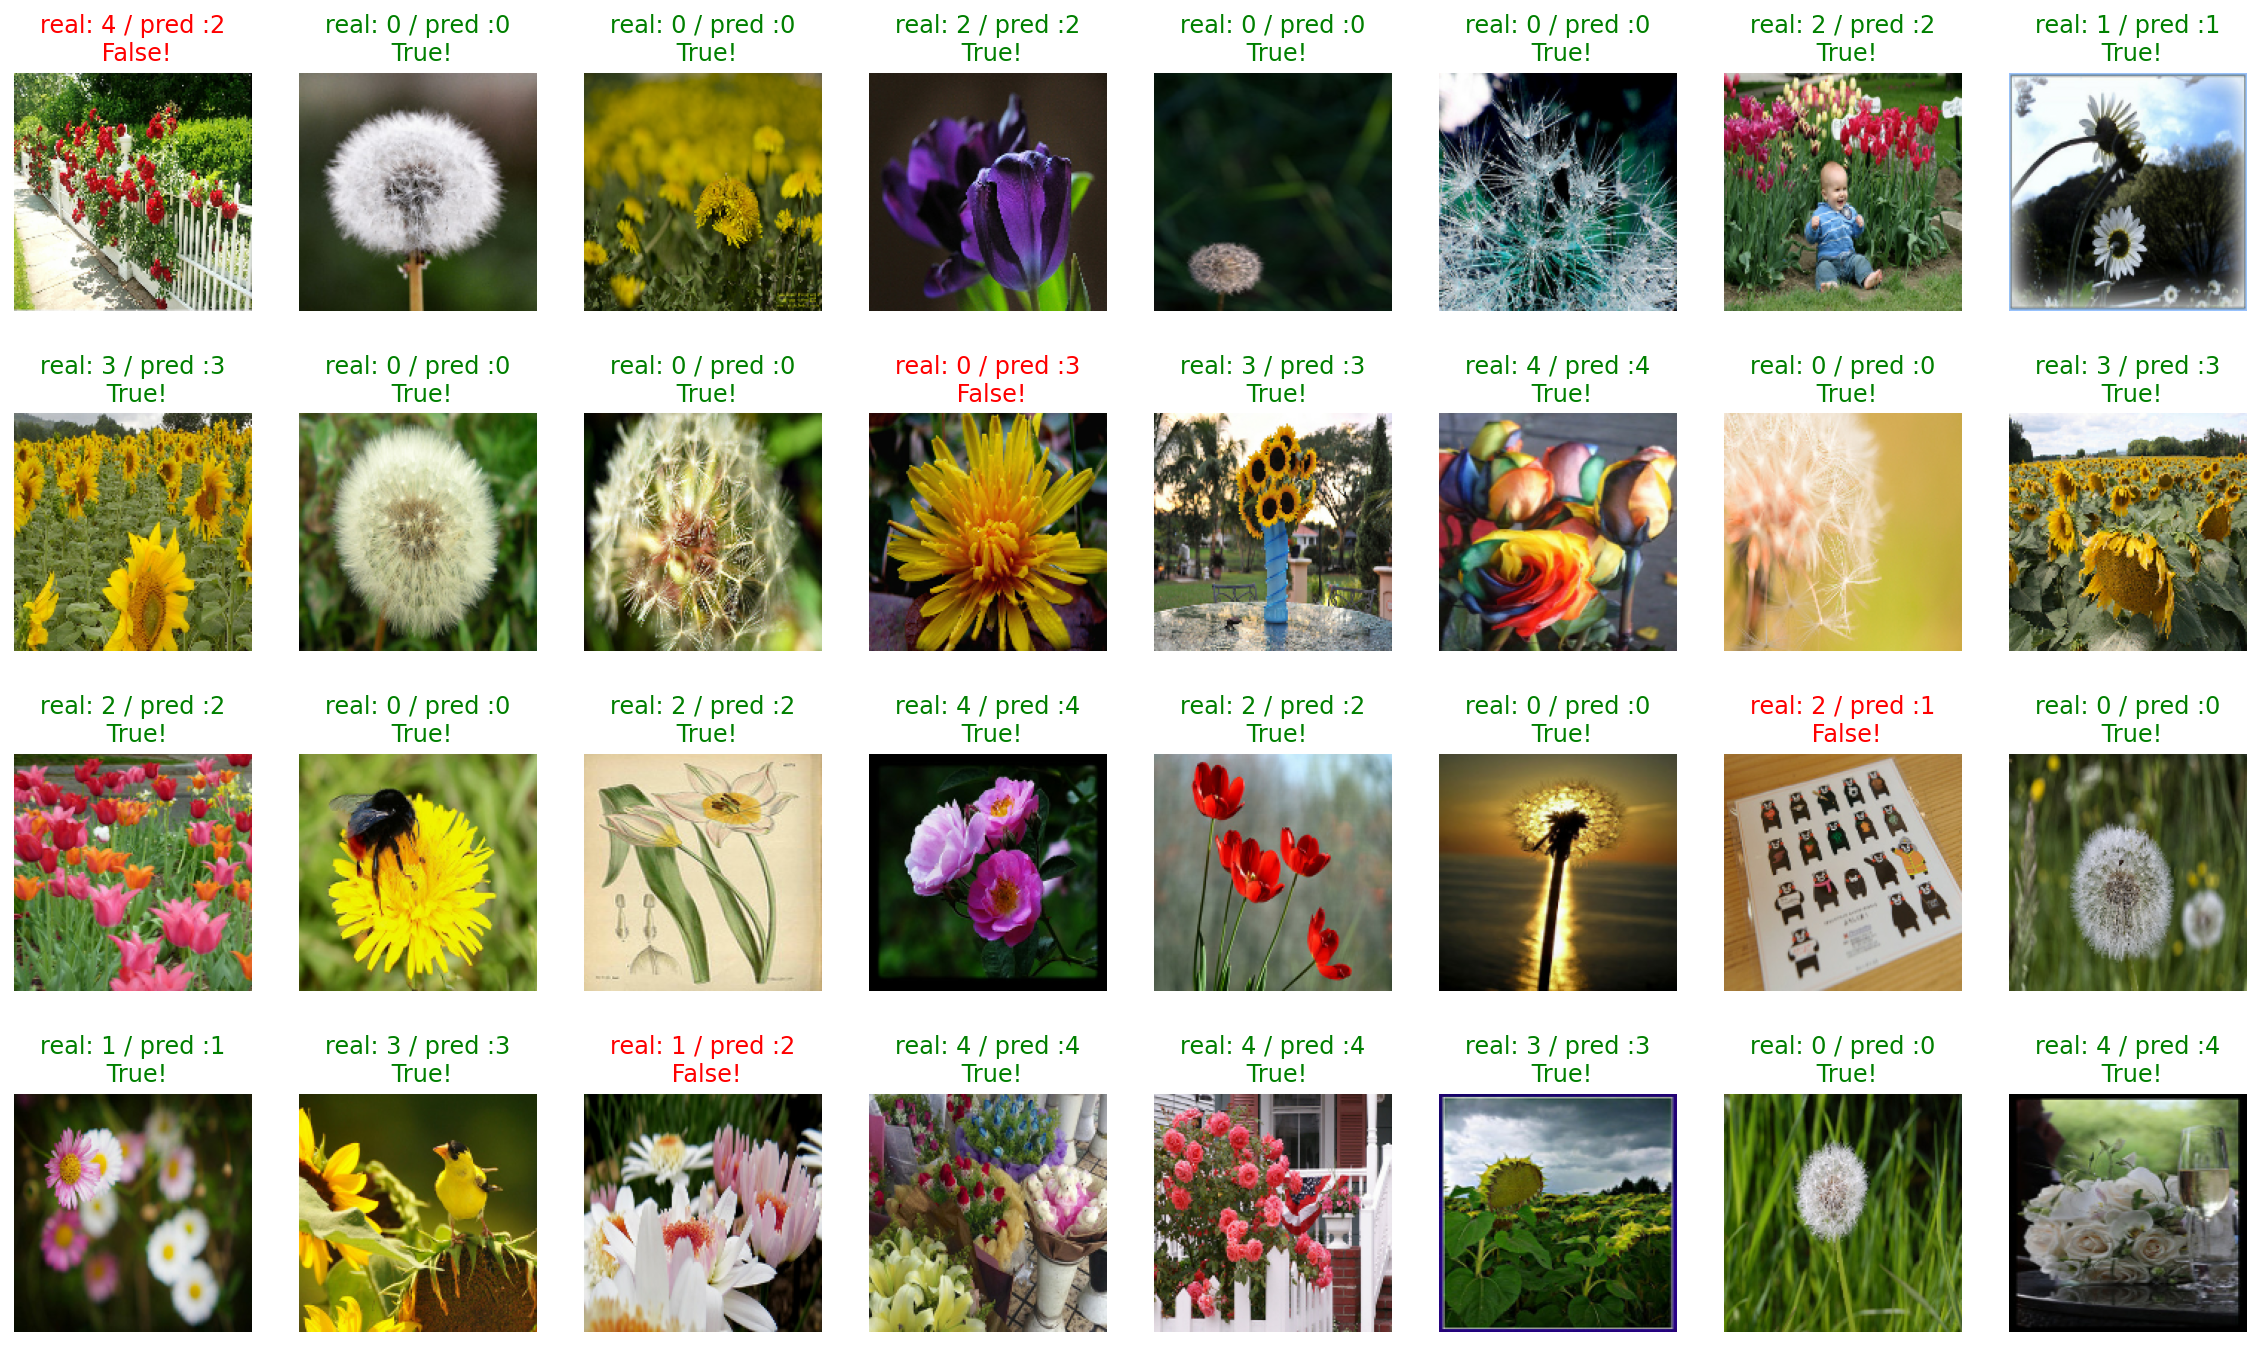

In [35]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, vgg_predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'green'})
    plt.axis('off')

In [36]:
count = 0
for image, label, prediction in zip(images, labels, vgg_predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 

87.5


## 5. Discussion and conclusion

## 6. Reference